I use [detectorn2](https://github.com/facebookresearch/detectron2) to deal with the faster RCNN

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from PIL import Image
import IPython
def cv2_imshow(img):
    img = img[:,:,[2,1,0]]
    img = Image.fromarray(img)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    #display(data=img)

In [3]:
import csv
train, test = [],[]
def take_path(x,d):
    with open(d) as t:
        #print(t.read())
        #print(type(csv.reader(t)))
        tmp = csv.reader(t,delimiter=' ')
        for i in tmp:
            x.append(i)
        for ele in x:
            ele[0] = '../PCBData/'+ele[0][:-4]+'_test.jpg'
            ele[1] = '../PCBData/'+ele[1]

take_path(test,'../PCBData/test.txt')
print(test[:5])
take_path(train,'../PCBData/trainval.txt')
print(train[:2])


[['../PCBData/group20085/20085/20085291_test.jpg', '../PCBData/group20085/20085_not/20085291.txt'], ['../PCBData/group20085/20085/20085292_test.jpg', '../PCBData/group20085/20085_not/20085292.txt'], ['../PCBData/group20085/20085/20085293_test.jpg', '../PCBData/group20085/20085_not/20085293.txt'], ['../PCBData/group20085/20085/20085294_test.jpg', '../PCBData/group20085/20085_not/20085294.txt'], ['../PCBData/group20085/20085/20085295_test.jpg', '../PCBData/group20085/20085_not/20085295.txt']]
[['../PCBData/group20085/20085/20085000_test.jpg', '../PCBData/group20085/20085_not/20085000.txt'], ['../PCBData/group20085/20085/20085001_test.jpg', '../PCBData/group20085/20085_not/20085001.txt']]


In [6]:
height, width = cv2.imread('../PCBData/group20085/20085/20085291_test.jpg').shape[:2]
print(height, width)
#DatasetCatalog.clear()

640 640


In [7]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
def get_PCB_dict(data_list):
    dataset_dicts = []
    
    for i,path in enumerate(data_list):
        filename = path[0]
        height, width = cv2.imread(filename).shape[:2]
        record = {}
        record['file_name'] = filename
        record['image_id'] = i
        record['height']= height
        record['width']= width
        
        #for i in data_list[1] to get bbox and category
        objs = []
        with open(path[1]) as t:
            lines = t.readlines()
            for line in lines:
                box = line[:-1].split(' ')
                boxes = list(map(float,[box[0],box[1],box[2],box[3]]))
                category = int(box[4])

                obj = {
                    "bbox": boxes,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    #"segmentation": [poly], To draw a line, along to ballon
                    "category_id": category-1,
                    "iscrowd": 0
                }
                objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts #list of dicts

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d,x in [("train",train), ("test",test)]:
    DatasetCatalog.register("PCB_" + d, lambda x=x: get_PCB_dict(x))
    MetadataCatalog.get("PCB_" + d).set(thing_classes=["open", "short", "mousebite", "spur", "copper", "pin-hole"],thing_colors=[(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)])
    #I set the colors, but it's no use. Retry after training.
PCB_metadata = MetadataCatalog.get("PCB_train")

In [9]:
#check dataset
print(type(PCB_metadata))
MetadataCatalog.get("PCB_test")

<class 'detectron2.data.catalog.Metadata'>


Metadata(name='PCB_test', thing_classes=['open', 'short', 'mousebite', 'spur', 'copper', 'pin-hole'], thing_colors=[(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)])

In [10]:
dataset_dicts = get_PCB_dict(train)

In [11]:
print(dataset_dicts[0])
print(dataset_dicts[1])

{'file_name': '../PCBData/group20085/20085/20085000_test.jpg', 'image_id': 0, 'height': 640, 'width': 640, 'annotations': [{'bbox': [409.0, 394.0, 435.0, 422.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [275.0, 383.0, 319.0, 417.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, {'bbox': [8.0, 163.0, 36.0, 191.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}, {'bbox': [244.0, 151.0, 270.0, 182.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 4, 'iscrowd': 0}, {'bbox': [338.0, 519.0, 364.0, 543.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 5, 'iscrowd': 0}, {'bbox': [476.0, 460.0, 502.0, 481.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 3, 'iscrowd': 0}]}
{'file_name': '../PCBData/group20085/20085/20085001_test.jpg', 'image_id': 1, 'height': 640, 'width': 640, 'annotations': [{'bbox': [335.0, 208.0, 364.0, 233.0], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'category_id': 2, 'iscrowd': 0}, 

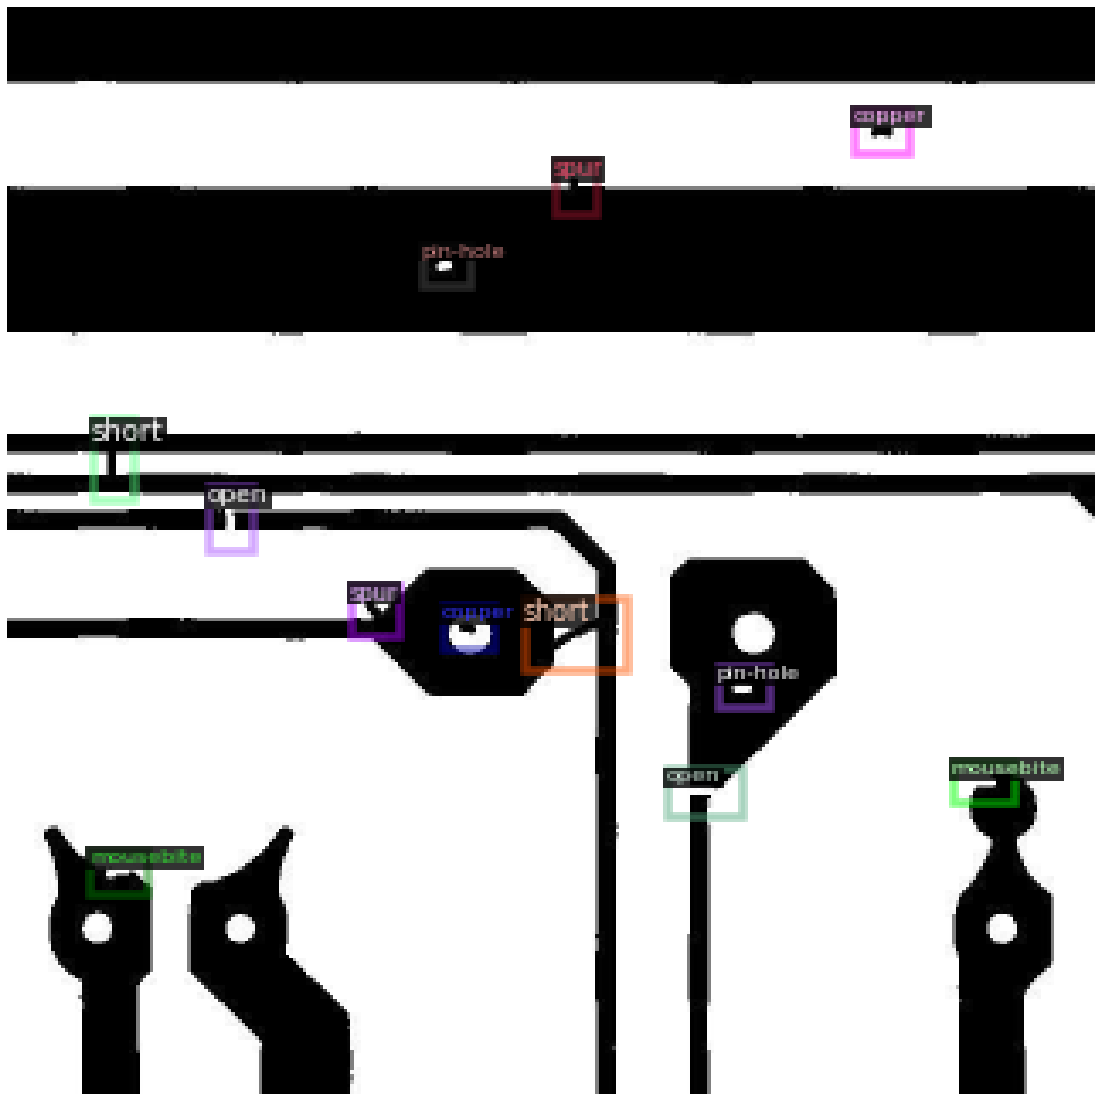

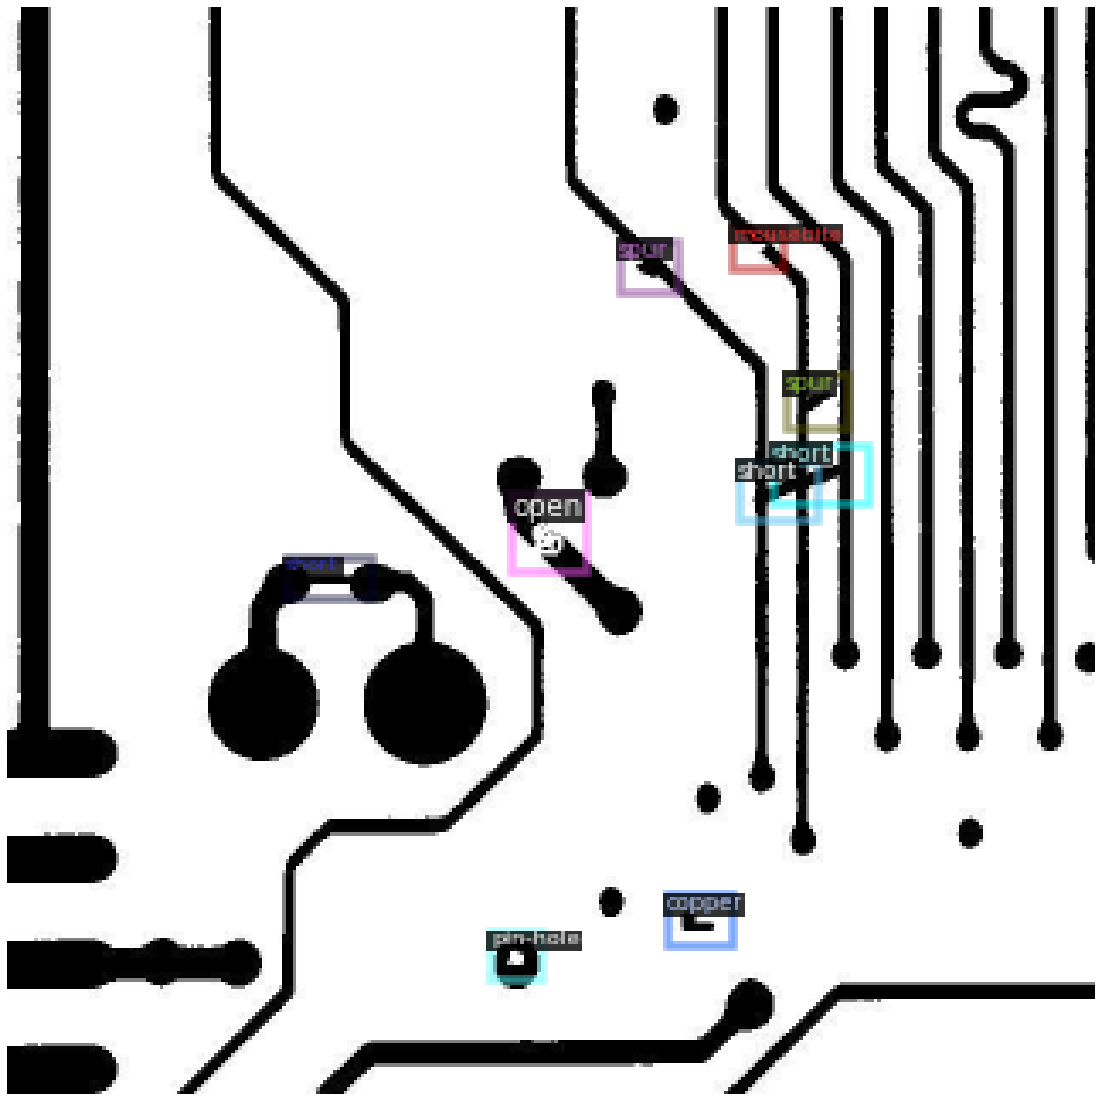

In [12]:
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=PCB_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [15]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("PCB_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 30000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/15 10:07:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (7, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (7,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (24, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (24,) in the model! Skipped.


[01/15 10:07:57 d2.engine.train_loop]: Starting training from iteration 0
[01/15 10:08:04 d2.utils.events]: eta: 3:15:34  iter: 19  total_loss: 2.974  loss_cls: 2.285  loss_box_reg: 0.030  loss_rpn_cls: 0.494  loss_rpn_loc: 0.136  time: 0.3730  data_time: 0.1136  lr: 0.000005  max_mem: 3821M
[01/15 10:08:12 d2.utils.events]: eta: 3:18:19  iter: 39  total_loss: 2.674  loss_cls: 2.092  loss_box_reg: 0.035  loss_rpn_cls: 0.454  loss_rpn_loc: 0.136  time: 0.3880  data_time: 0.1312  lr: 0.000010  max_mem: 3821M
[01/15 10:08:20 d2.utils.events]: eta: 3:16:42  iter: 59  total_loss: 2.168  loss_cls: 1.710  loss_box_reg: 0.034  loss_rpn_cls: 0.326  loss_rpn_loc: 0.150  time: 0.3883  data_time: 0.1338  lr: 0.000015  max_mem: 3821M
[01/15 10:08:28 d2.utils.events]: eta: 3:17:01  iter: 79  total_loss: 1.596  loss_cls: 1.188  loss_box_reg: 0.039  loss_rpn_cls: 0.214  loss_rpn_loc: 0.150  time: 0.3868  data_time: 0.1369  lr: 0.000020  max_mem: 3821M
[01/15 10:08:36 d2.utils.events]: eta: 3:16:17  it

OrderedDict()

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("PCB_test", )
predictor = DefaultPredictor(cfg)

In [17]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_PCB_dict(test)

tensor([5, 5, 2, 4, 1, 0, 1], device='cuda:0')
Boxes(tensor([[277.2265, 475.5229, 304.0905, 513.1672],
        [322.2088, 416.1968, 347.4139, 452.3609],
        [225.3169, 332.7007, 260.6636, 359.1148],
        [ 88.5679, 318.7495, 126.2468, 367.6035],
        [336.6426, 264.2759, 384.7824, 296.2274],
        [379.9219, 358.7953, 411.9414, 388.4621],
        [473.9243, 131.4870, 498.9346, 180.2203]], device='cuda:0'))


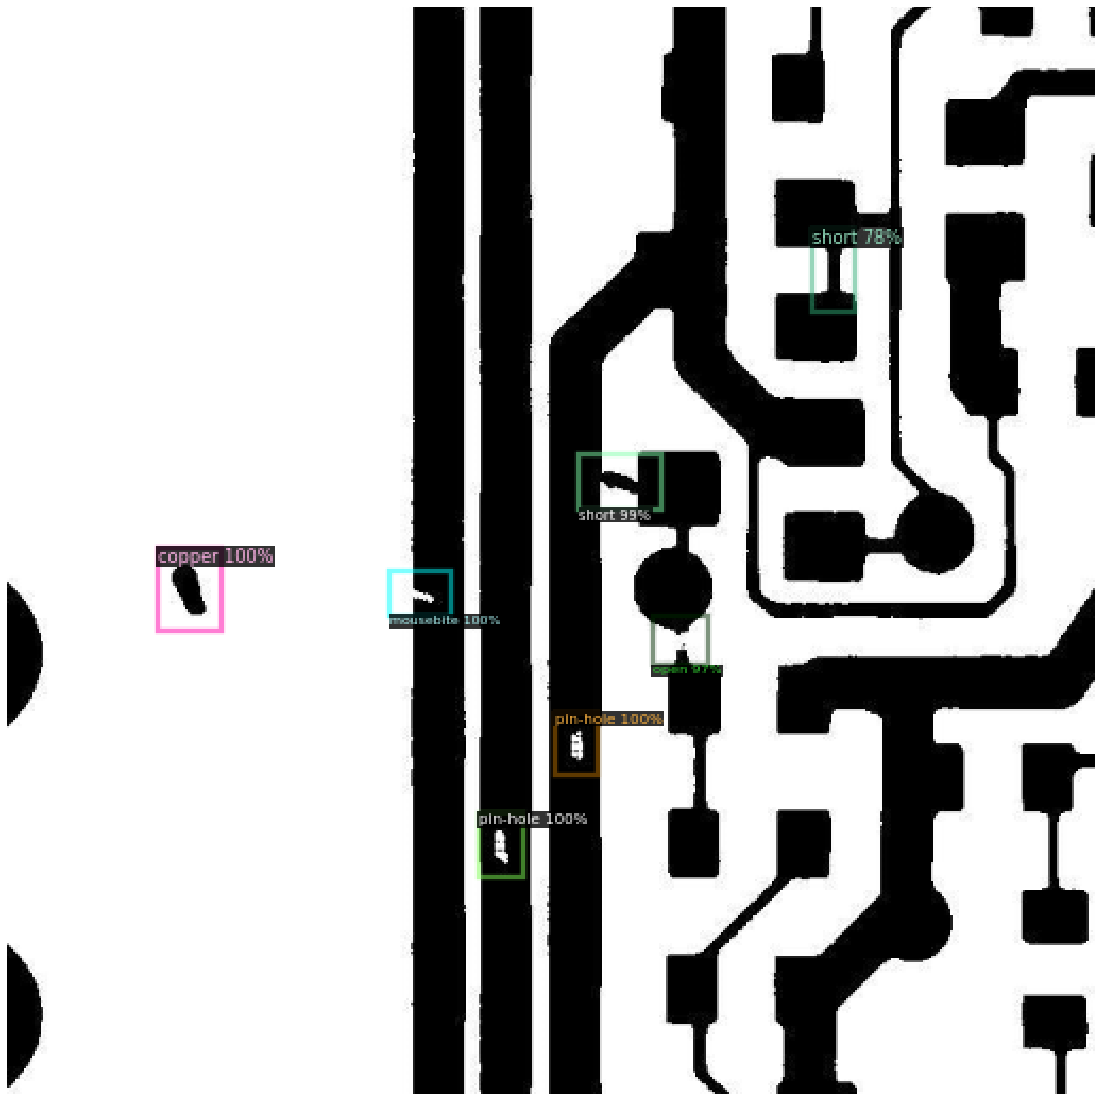

tensor([4, 3, 0, 5, 0, 1], device='cuda:0')
Boxes(tensor([[111.7365, 153.9872, 150.3078, 185.7240],
        [184.8593, 318.7358, 221.9417, 345.4976],
        [107.9791, 321.5527, 137.6294, 355.0972],
        [264.7780, 130.7728, 300.3863, 158.3875],
        [177.1459, 445.3758, 211.2686, 470.7129],
        [552.6867, 434.9174, 580.6249, 472.0403]], device='cuda:0'))


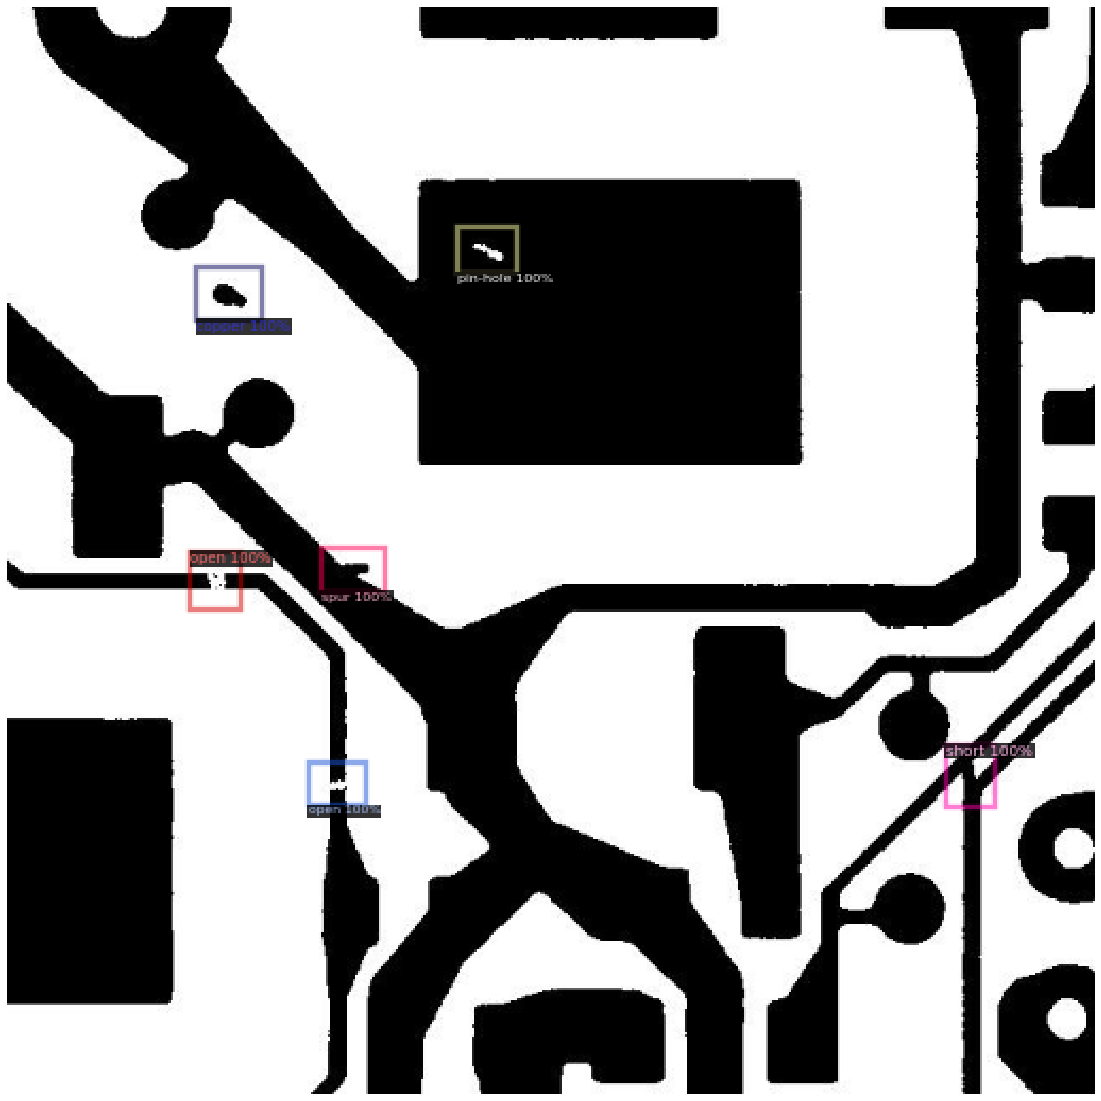

tensor([0, 2, 5, 1, 2], device='cuda:0')
Boxes(tensor([[211.7280, 358.1145, 254.9899, 394.3965],
        [145.9731, 491.5108, 182.3428, 519.2375],
        [ 69.4653, 424.6019, 101.1593, 449.9253],
        [268.1546, 186.8174, 312.0065, 216.8097],
        [238.6253, 483.8670, 269.4651, 508.1195]], device='cuda:0'))


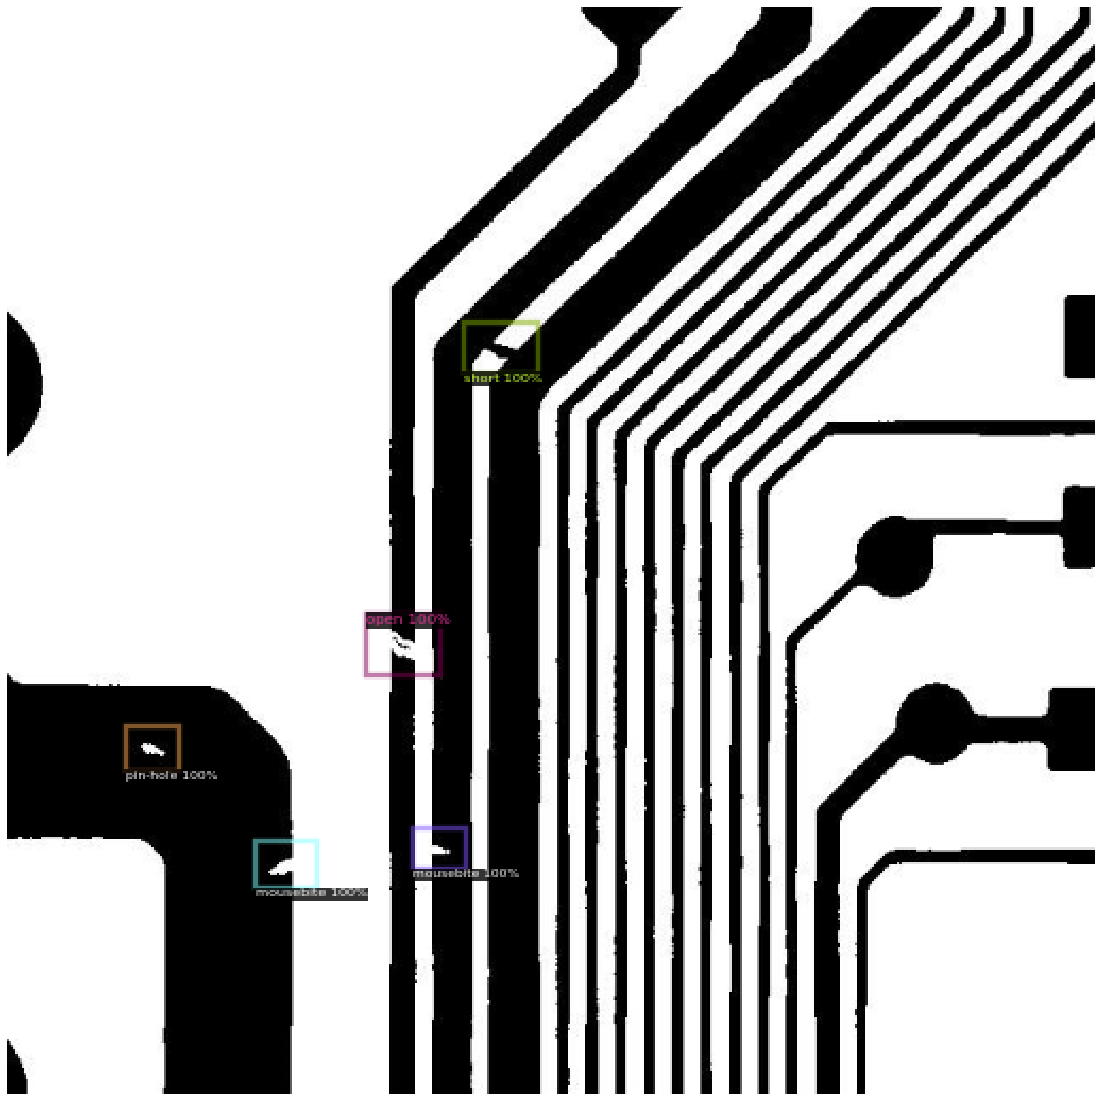

In [18]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im,
                   metadata=PCB_metadata, 
                   scale=0.8,
                   instance_mode =  ColorMode.IMAGE
        )
                   # remove the colors of unsegmented pixels
    print(outputs['instances'].pred_classes)
    print(outputs["instances"].pred_boxes)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("PCB_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "PCB_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [01/15 13:21:23 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'PCB_test'
[01/15 13:21:23 d2.data.datasets.coco]: Converting dataset annotations in 'PCB_test' to COCO format ...)
[01/15 13:21:27 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/15 13:21:28 d2.data.datasets.coco]: Conversion finished, num images: 500, num annotations: 3140
[01/15 13:21:28 d2.data.datasets.coco]: Caching annotations in COCO format: ./output/PCB_test_coco_format.json
[01/15 13:21:32 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    open    | 659          |   short    | 478          | mousebite  | 586          |
|    spur    | 483          |   copper   | 464          |  pin-hole  | 470          |
|            |              |            |              |     

OrderedDict([('bbox',
              {'AP': 75.20127272703013,
               'AP50': 96.76572332620502,
               'AP75': 90.01029581953819,
               'APs': 74.98562374933758,
               'APm': 76.00981275831774,
               'APl': 69.99999999999999,
               'AP-open': 68.51258294965088,
               'AP-short': 61.62459560598176,
               'AP-mousebite': 75.62379630017988,
               'AP-spur': 71.72528732774805,
               'AP-copper': 88.51582370152634,
               'AP-pin-hole': 85.20555047709392})])